In [1]:
import os
import json
import hoomd
import codecs
import pyximport

import numpy as np

import polychrom_hoomd.log as log
import polychrom_hoomd.build as build
import polychrom_hoomd.forces as forces
import polychrom_hoomd.render as render
import polychrom_hoomd.extrude as extrude

pyximport.install(setup_args={"include_dirs":np.get_include()}, reload_support=True)

from polykit.generators.initial_conformations import grow_cubic
from LEF_dynamics.lattice_translocators import LEFTranslocatorDirectional

In [2]:
# Initialise HOOMD on the CPU or GPU, based on availability
hoomd_device = build.get_hoomd_device()

HOOMD is running on the following GPU(s):
[0]  Tesla P100-PCIE-16GB  56 SM_6.0 @ 1.33 GHz, 16280 MiB DRAM


In [3]:
# Generate RNG seed
rng_seed = os.urandom(2)
rng_seed = int(codecs.encode(rng_seed, 'hex'), 16)

print("Using entropy-harvested random seed: %d" % rng_seed)

Using entropy-harvested random seed: 34506


In [4]:
# Initialize empty simulation object
system = hoomd.Simulation(device=hoomd_device, seed=rng_seed)

In [5]:
# Simulate two chromosomes comprised of 5000 (resp. 10000) monomers each, with number density 0.2
density = 0.2
chromosome_sizes = [5000, 10000]

In [6]:
# Confine chromosomes within a sphere of appropriate radius
number_of_monomers = sum(chromosome_sizes)
confinement_radius = (3*number_of_monomers / (4*np.pi*density))**(1/3.)

In [7]:
# Set simulation box large enough to accomodate the chromosomes
snapshot = build.get_simulation_box(box_length=2*confinement_radius, pad=1.)

In [8]:
# Build random, dense initial conformations
inscribed_cube_length = confinement_radius*2/3**.5
monomer_positions = grow_cubic(N=number_of_monomers, boxSize=int(inscribed_cube_length))

In [9]:
with open("force_dict_full.json", 'r') as dict_file:
    force_dict = json.load(dict_file)

In [10]:
bond_types = force_dict['Bonded forces'].keys()
angle_types = force_dict['Angular forces'].keys()
monomer_types = force_dict['Non-bonded forces']['Attraction']['Matrix'].keys()

In [11]:
# Populate snapshot with the generated chains
build.set_chains(snapshot, monomer_positions, chromosome_sizes,
                 bond_type_list=list(bond_types), monomer_type_list=list(monomer_types),
                 angle_type_list=list(angle_types))

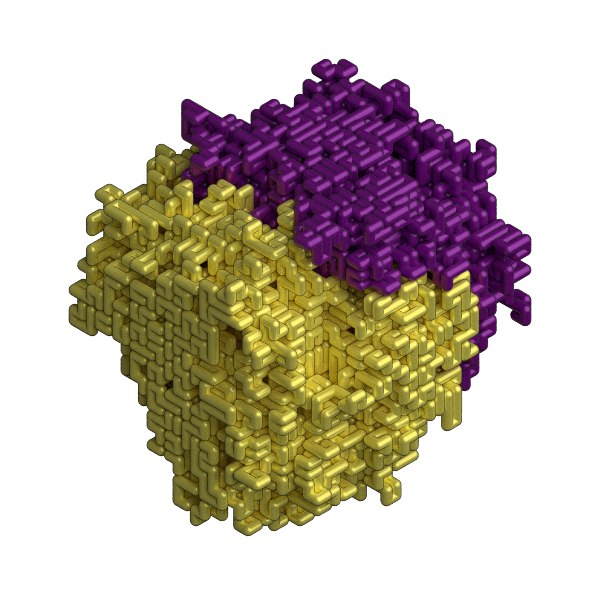

In [12]:
# Render individual chromosomes using the Fresnel backend
render.fresnel(snapshot, show_chromosomes=True)

In [13]:
# Setup domains by assigning monomers to a type 0 (A) or 1 (B)
domain_size = 500

motif = np.zeros(3*domain_size)
motif[domain_size:2*domain_size] = 1

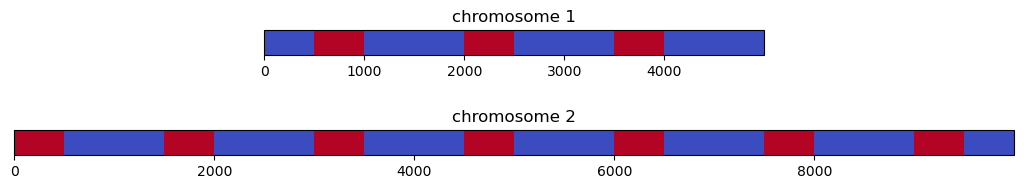

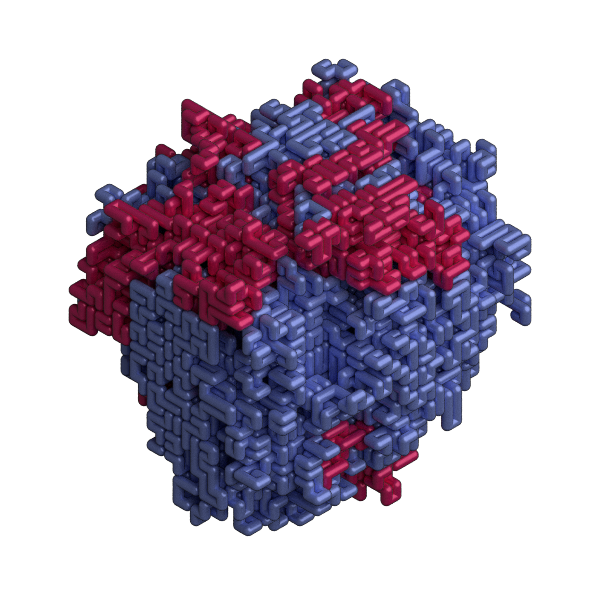

In [14]:
# Assign and visualize domains in 1D/3D
snapshot.particles.typeid[:] = np.tile(motif, number_of_monomers//motif.shape[0])

render.domain_viewer(snapshot, cmap="coolwarm")
render.fresnel(snapshot, show_compartments=True, cmap="coolwarm")

In [15]:
# Setup HooMD simulation object
system.create_state_from_snapshot(snapshot)

In [16]:
# Setup neighbor list
nl = hoomd.md.nlist.Cell(buffer=0.4)

In [17]:
# Set chromosome excluded volume
repulsion_forces = forces.get_repulsion_forces(nl, **force_dict)

In [18]:
# Set bonded/angular potentials
bonded_forces = forces.get_bonded_forces(**force_dict)
angular_forces = forces.get_angular_forces(**force_dict)

In [19]:
# Set spherical confining wall
force_dict['External forces']['Confinement']['Spherical'] = dict(R=confinement_radius)
confinement_forces = forces.get_confinement_forces(**force_dict)

In [20]:
# Set attractive/DPD forces
dpd_forces = forces.get_dpd_forces(nl, **force_dict)
attraction_forces = forces.get_attraction_forces(nl, **force_dict)

In [21]:
# Define full force_field
force_field = repulsion_forces + bonded_forces + angular_forces + confinement_forces \
            + dpd_forces + attraction_forces

In [22]:
# Setup DPD integrator
nve = hoomd.md.methods.NVE(filter=hoomd.filter.All())
dpd_integrator = hoomd.md.Integrator(dt=5e-3, methods=[nve], forces=force_field)

/home1/tortora/.conda/envs/polychrom-hoomd/lib/python3.11/site-packages/hoomd/md/methods/methods.py:699: FutureWarning: NVE is deprecated and wil be removed in hoomd 4.0. In version 4.0, use the ConstantVolume method without a thermostat.
  warnings.warn(


In [23]:
# Setup log and simulation engines
logger = log.get_logger(system)

system.operations.integrator = dpd_integrator
system.operations.writers.append(log.table_formatter(logger, period=10000))

In [24]:
# Run
system.run(1e5)

Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
       10000           2221.82522     0:00:40.507237           0.93112          
       20000           2811.94145     0:00:28.450095           0.99166          
       30000           3116.03105     0:00:22.464474           1.01813          
       40000           3292.07059     0:00:18.225612           1.02533          
       50000           3407.18416     0:00:14.674874           1.02393          
       60000           3463.97650     0:00:11.547422           1.02567          
       70000           3522.50867     0:00:08.516658           1.04210          
       80000           3566.90046     0:00:05.607109           1.01910          
       90000           3603.70180     0:00:02.774924           1.01910          
      100000           3630.97350        0:00:00               1.02302          


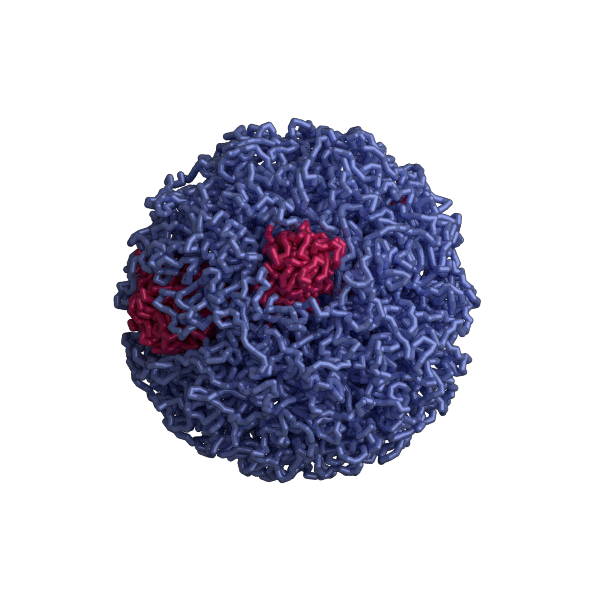

In [25]:
# Visualize equilibrated domains in 3D
snapshot_equilibrated = system.state.get_snapshot()
render.fresnel(snapshot_equilibrated, show_compartments=True, cmap="coolwarm")

In [26]:
# Parse extrusion parameters
with open("extrusion_dict.json", 'r') as dict_file:
    extrusion_dict = json.load(dict_file)
    
extrusion_dict['LEF_lifetime'] *= extrusion_dict['LEF_velocity']
extrusion_dict['LEF_stall'] = 1 - (1-extrusion_dict['LEF_stall'])**(1/extrusion_dict['LEF_velocity'])

In [27]:
# Add loop extruders
LEF_pos = extrude.compute_LEF_pos(LEFTranslocatorDirectional, number_of_monomers, **extrusion_dict)

extrude.update_topology(system, LEF_pos[0])

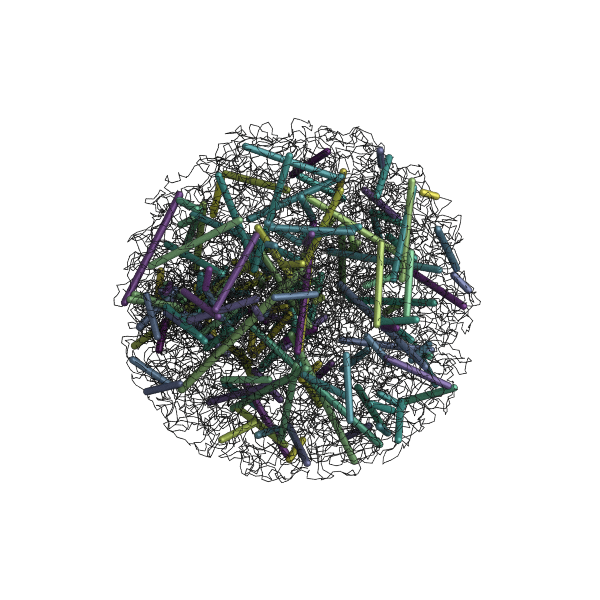

In [28]:
# Visualize new CTCF bonds 
snapshot_looped = system.state.get_snapshot()
render.fresnel(snapshot_looped, show_loops=True)

In [29]:
# Define relaxation force field
relax_field = repulsion_forces + bonded_forces + confinement_forces

In [30]:
# Relax CTCF bonds via the fast inertial relaxation engine
system.operations.remove(dpd_integrator)
system.operations.remove(system.operations.writers[0])

fire = hoomd.md.minimize.FIRE(dt=1e-2, methods=[nve], forces=relax_field,
                              force_tol=5e-2, angmom_tol=5e-2, energy_tol=5e-2)

In [31]:
# Update simulation engine
system.operations.integrator = fire
system.operations.writers.append(log.table_formatter(logger, period=100))

In [32]:
# Run
system.run(1e3)

Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
      100100           147.94602      0:00:06.083300           0.21090          
      100200           256.32637      0:00:03.121021           0.06797          
      100300           346.12571      0:00:02.022387           0.04244          
      100400           402.99896      0:00:01.488838           0.03313          
      100500           475.75780      0:00:01.050955           0.00025          
      100600           562.20957      0:00:00.711478           0.00010          
      100700           655.37251      0:00:00.457755           0.00010          
      100800           748.58645      0:00:00.267170           0.00010          
      100900           841.65470      0:00:00.118814           0.00010          
      101000           934.50251         0:00:00               0.00010          


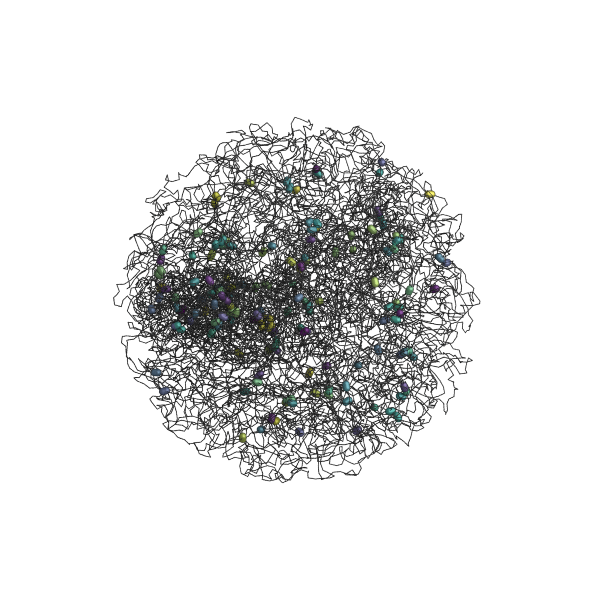

In [33]:
# Visualize new conformation
snapshot_relaxed = system.state.get_snapshot()
render.fresnel(snapshot_relaxed, show_loops=True)

In [34]:
# Update simulation engine
system.operations.remove(fire)
system.operations.remove(system.operations.writers[0])

system.operations.integrator = dpd_integrator
system.operations.writers.append(log.table_formatter(logger, period=10000))

In [35]:
# Run
steps_per_loop = extrusion_dict['3D_to_1D_steps']/extrusion_dict['LEF_velocity']

for LEF_bonds in LEF_pos:
    extrude.update_topology(system, LEF_bonds, thermalize=False)    
    system.run(steps_per_loop)

Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
      110000           2357.73610        0:00:00               1.77128          
      120000           2348.38740        0:00:00               2.19562          
      130000           2392.71844        0:00:00               2.16039          
      140000           2397.61925        0:00:00               2.18175          
      150000           2427.33250        0:00:00               2.19747          
      160000           2368.42732        0:00:00               2.18337          
      170000           2399.41160        0:00:00               2.16814          
      180000           2426.23750        0:00:00               2.06863          
      190000           2398.51509        0:00:00               2.13655          
      200000           2416.28014        0:00:00               2.13249          
      210000           2323.02951        0:00:00               2.13161          
      220000           2423.

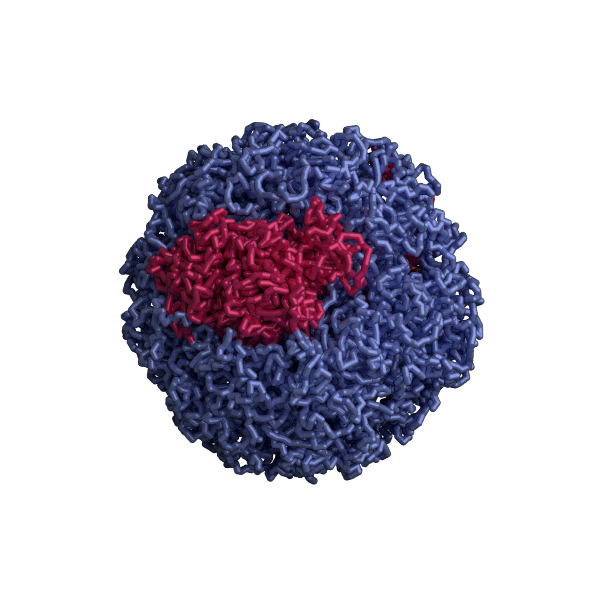

In [36]:
# Visualize new conformation
final_snapshot = system.state.get_snapshot()
render.fresnel(final_snapshot, show_compartments=True, cmap="coolwarm")

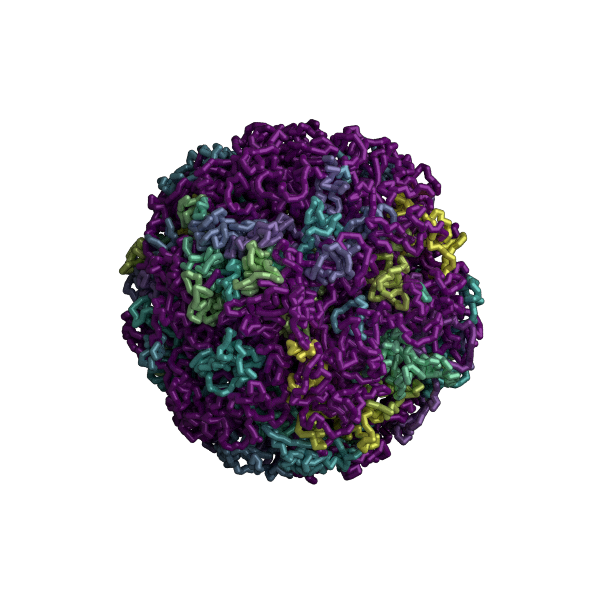

In [37]:
# Visualize individual loops
render.fresnel(final_snapshot, show_loops=True, rescale_bonds=1)